In [12]:
import c3d 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from scipy.signal import correlate, correlation_lags
import os
import pickle

with open('2.IMU_Joint_Angles.pkl', 'rb') as f:
    IMU = pickle.load(f)

with open('3.OPTO_Joint_Angles.pkl', 'rb') as f:
    OPTO = pickle.load(f)
    
def align_signals(opto, imu, plotting=True):
    if plotting:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(15,5))
        ax1.plot(opto, color='black')
        ax1.plot(imu, color='red')
        ax1.set_title('Raw Signals')
        ax1.legend(['OPTO', 'IMU-NP'])

    correlation = correlate(opto - np.mean(opto), imu - np.mean(imu), mode='full', method='direct')
    lags = correlation_lags(opto.size, imu.size, mode='full')
    lag = lags[np.argmax(correlation)]
    if plotting:
        ax2.plot(lags, correlation)
        ax2.plot(lags[np.argmax(correlation)], correlation[np.argmax(correlation)], marker='o', markersize=15)
        ax2.set_title(f'Correlation - Delay={lag} frames', fontweight='bold')

    # Quick way to check if signals are aligned properly
    if lag>=0 and plotting:
        ax3.plot(opto[lag:], color='black')
        ax3.plot(imu, color='red')
        ax3.set_title('Aligned Signals')
        ax3.legend(['OPTO', 'IMU-NP'])
    elif lag<0 and plotting:
        ax3.plot(opto, color='black')
        ax3.plot(imu[abs(lag):], color='red')
        ax3.set_title('Aligned Signals')
        ax3.legend(['OPTO', 'IMU-NP'])

    ### Now we need to find the matching indices to align the IMU signal to the opto signal. We don't touch the OPTO since it is our reference
    # 4 conditions exist:
    # 1) len(imu) > len(opto) and lag > 0 -> imu simply needs to be cropped and imu is shifted forward
    # 2) len(imu) < len(opto) and lag > 0 -> imu needs to be padded and imu is shifted forward
    # 3) len(imu) > len(opto) and lag < 0 -> imu needs to be cropped and imu is shifted backward
    # 4) len(imu) < len(opto) and lag < 0 -> imu needs to be padded and imu is shifted backward

    if len(imu) >= len(opto) and lag >= 0:
        print('Condition 1) imu > opto and lag +')
        # This condition doesn't occur with our dataset. We add it for completeness but it is not double checked
        first_frame_opto = lag
        last_frame_opto = len(imu)
        first_frame_imu = len(opto)-len(imu)
        last_frame_imu = len(imu)-lag
    elif len(imu) < len(opto) and lag >= 0:
        print('Condition 2) imu < opto and lag +')
        first_frame_opto = lag
        last_frame_opto = len(imu)
        first_frame_imu = 0
        last_frame_imu = len(imu)-lag
    elif len(imu) >= len(opto) and lag < 0:
        print('Condition 3) imu > opto and lag -')
        first_frame_opto = 0
        last_frame_opto = len(imu)- abs(lag)
        first_frame_imu = abs(lag)
        last_frame_imu = len(imu)
    elif len(imu) < len(opto) and lag < 0:
        print('Condition 4) imu < opto and lag -')
        first_frame_opto = 0
        last_frame_opto = len(imu) - abs(lag)
        first_frame_imu = abs(lag)
        last_frame_imu = len(imu)
    
    if plotting:
        ax4.plot(opto[first_frame_opto:last_frame_opto], color='black')
        ax4.plot(imu[first_frame_imu:last_frame_imu], color='red')
        ax4.legend(['OPTO', 'IMU-NP'])
        ax4.set_title('Signals aligned and cropped')
        
    return first_frame_opto, last_frame_opto, first_frame_imu, last_frame_imu


Condition 2) imu < opto and lag +
Condition 2) imu < opto and lag +
Condition 3) imu > opto and lag -
Condition 4) imu < opto and lag -
Condition 4) imu < opto and lag -
Condition 3) imu > opto and lag -
Condition 4) imu < opto and lag -
Condition 2) imu < opto and lag +
Condition 2) imu < opto and lag +
Condition 4) imu < opto and lag -


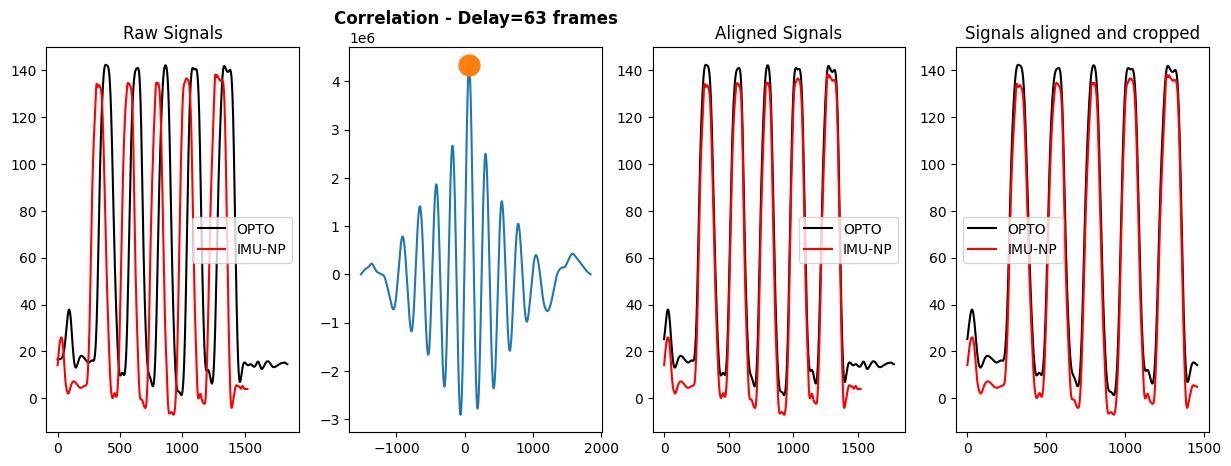

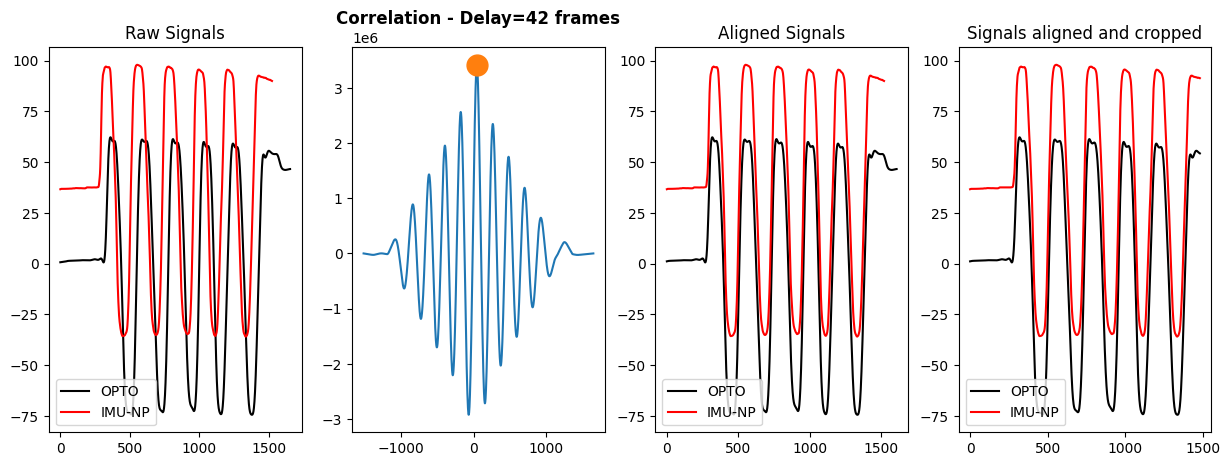

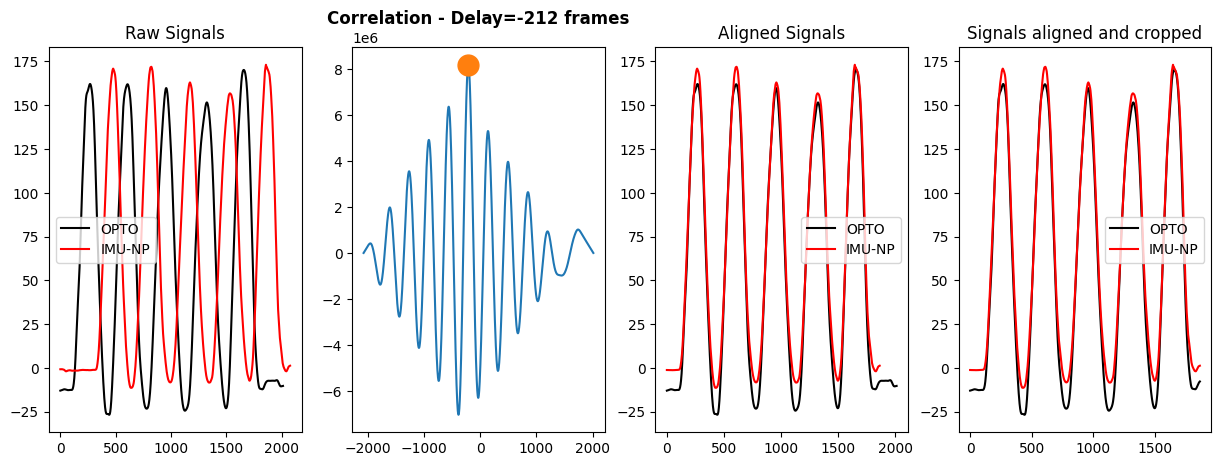

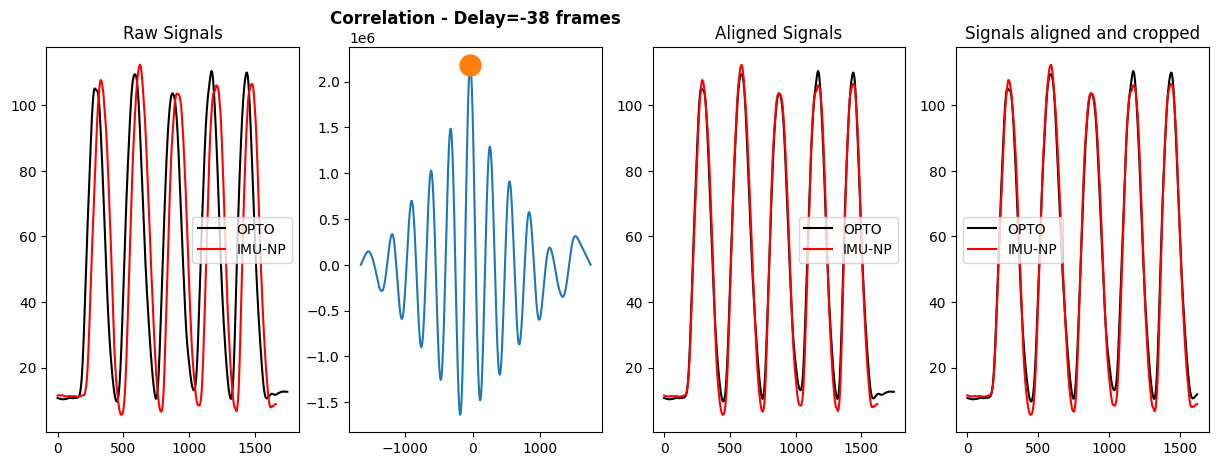

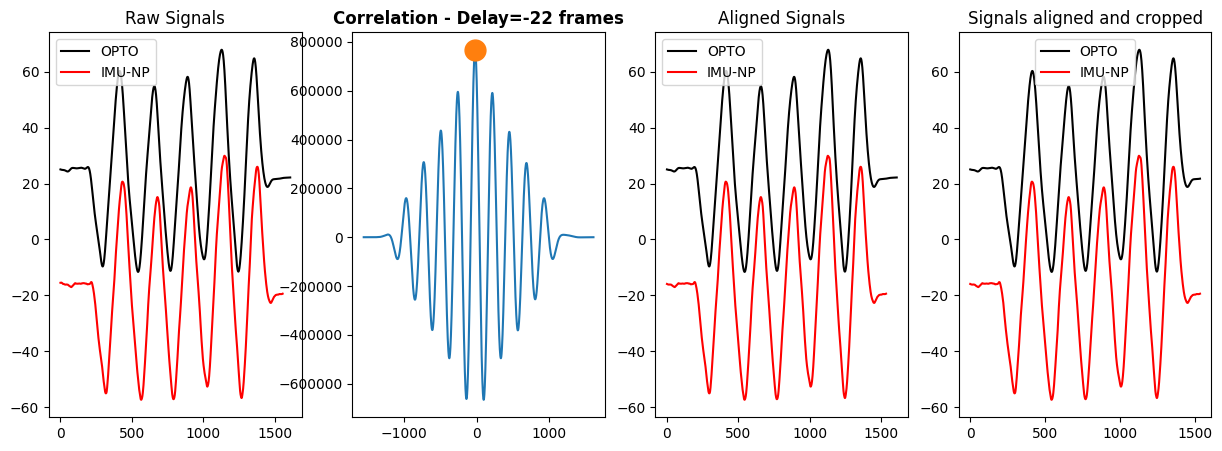

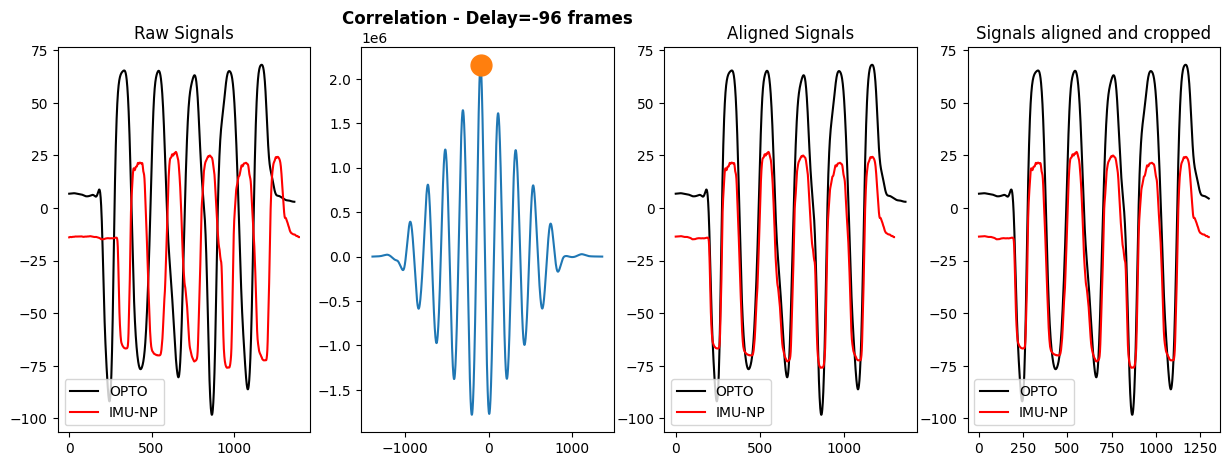

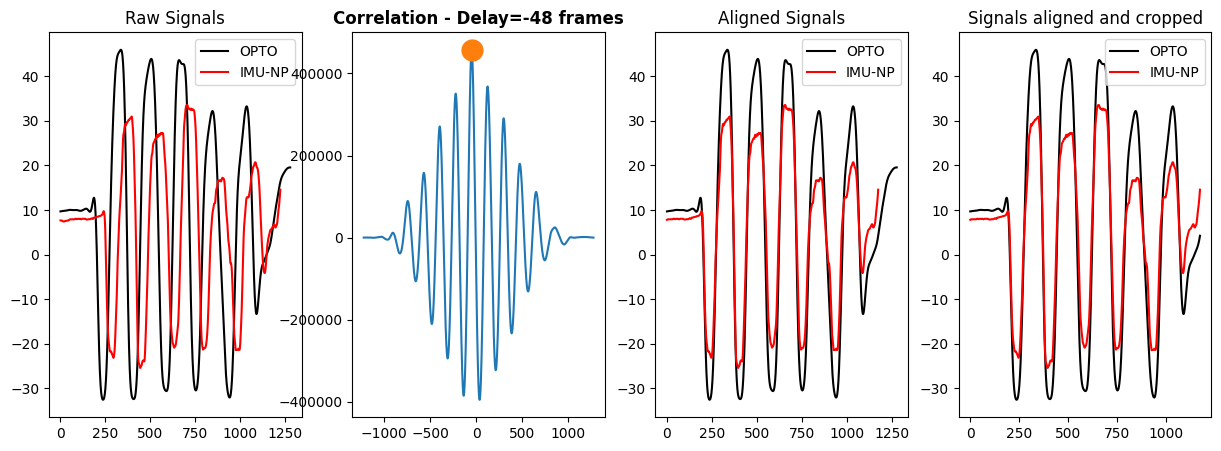

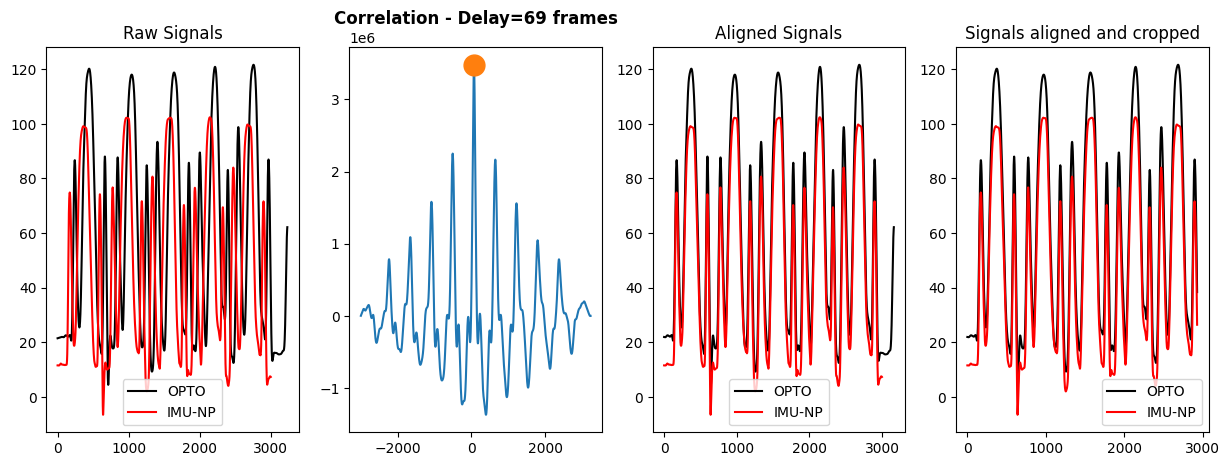

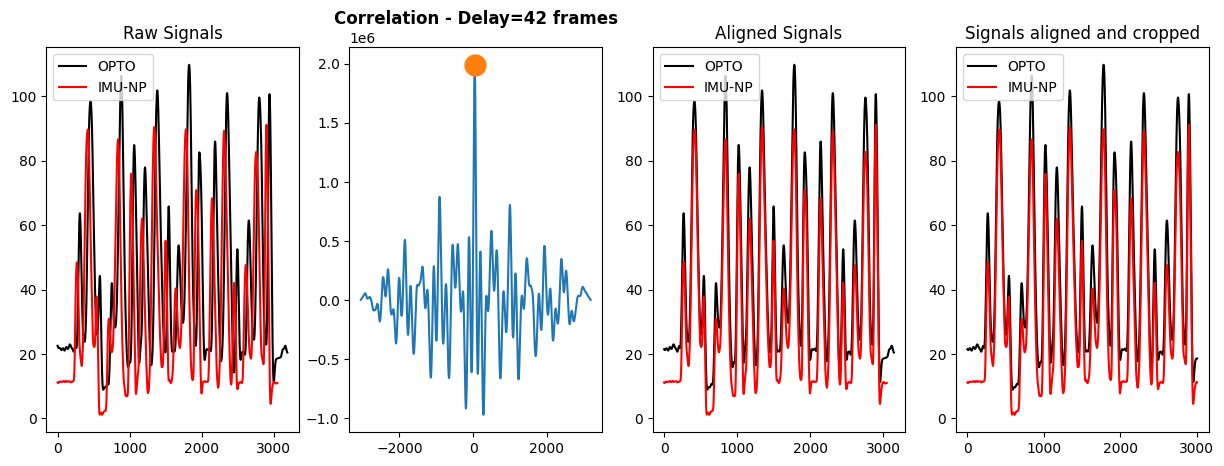

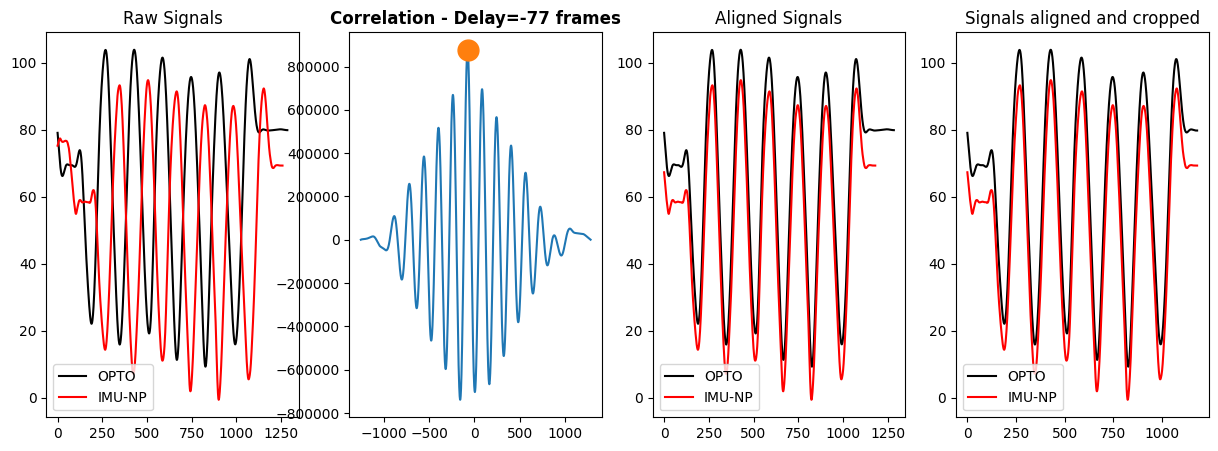

In [14]:
#### Align OPTO and IMU data

# use a combination of joint/axes to align the data
alignment_dict = {
    0: {'Joint': 'Right Elbow', 'Axis': 0},
    1: {'Joint': 'Right Elbow', 'Axis': 1},
    2: {'Joint': 'Right Shoulder', 'Axis': 0},
    3: {'Joint': 'Right Shoulder', 'Axis': 2},
    4: {'Joint': 'Right Shoulder', 'Axis': 1},
    5: {'Joint': 'Right Wrist', 'Axis': 0},
    6: {'Joint': 'Right Wrist', 'Axis': 2},
    7: {'Joint': 'Right Elbow', 'Axis': 0},
    8: {'Joint': 'Right Elbow', 'Axis': 0},
    9: {'Joint': 'Right Elbow', 'Axis': 0},
}


IMU_aligned = {}
OPTO_aligned = {}
jointNames = ['Right Shoulder', 'Right Elbow', 'Right Wrist']

for task in range(len(OPTO)):
    
    IMU_aligned[task] = {
        'Task Name': '',
        'Right Shoulder': [],
        'Right Elbow': [],
        'Right Wrist': []
    }
    OPTO_aligned[task] = {
        'Task Name': '',
        'Right Shoulder': [],
        'Right Elbow': [],
        'Right Wrist': []
    }
    
    # Select the correct combination of joint/axis to align the two signals using the point of maximum cross-correlation
    joint = alignment_dict[task]['Joint']
    axis = alignment_dict[task]['Axis']
    
    opto = OPTO[task][joint][:,axis]
    imu = IMU[task][joint][:,axis]
    
    # Use the function align_signal to get the first and last frames to perform the alignment on all data
    first_frame_opto, last_frame_opto, first_frame_imu, last_frame_imu = align_signals(opto, imu, True)
    
    OPTO_aligned[task]['Task Name'] = OPTO[task]['Task Name']
    IMU_aligned[task]['Task Name'] = IMU[task]['Task Name']

    for j in range(len(jointNames)):
        OPTO_aligned[task][jointNames[j]] = OPTO[task][jointNames[j]][first_frame_opto:last_frame_opto, :]
        IMU_aligned[task][jointNames[j]] = IMU[task][jointNames[j]][first_frame_imu:last_frame_imu, :]

with open('4.OPTO_IMU_Joint_Angles_aligned.pkl', 'wb') as f:
    pickle.dump((OPTO_aligned,IMU_aligned), f)
    

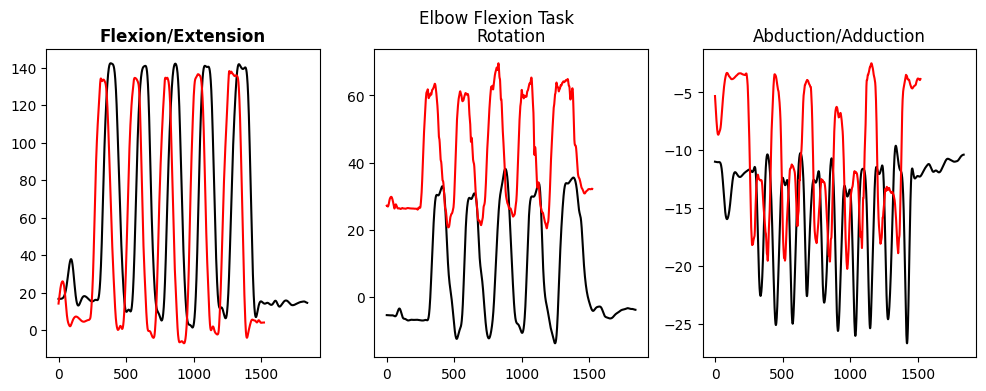

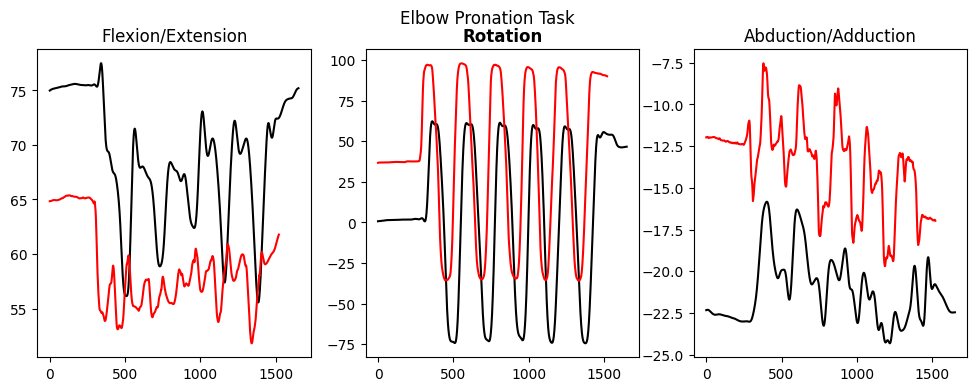

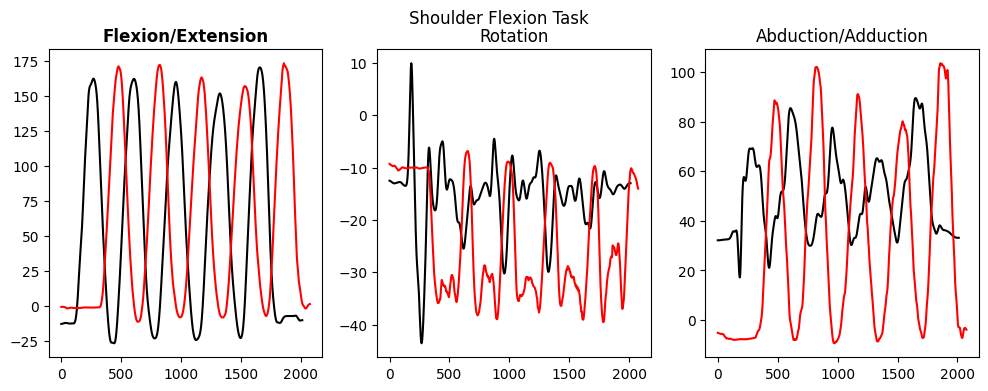

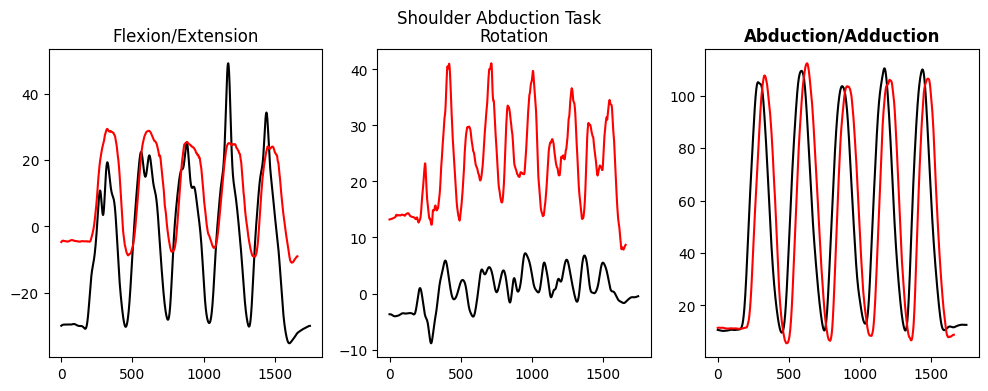

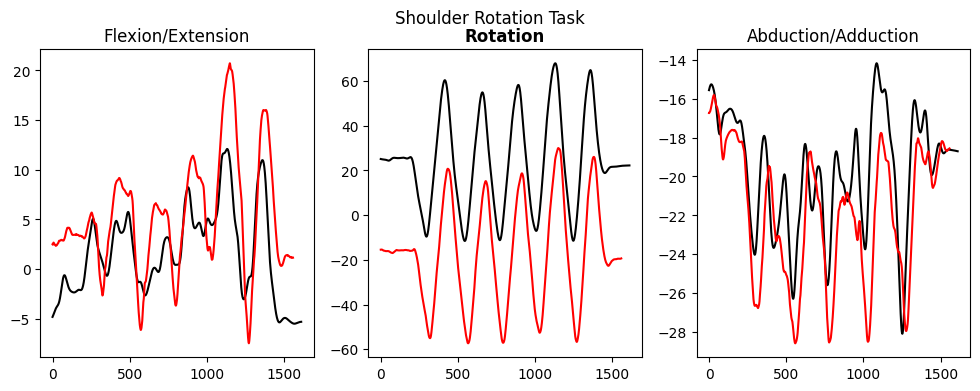

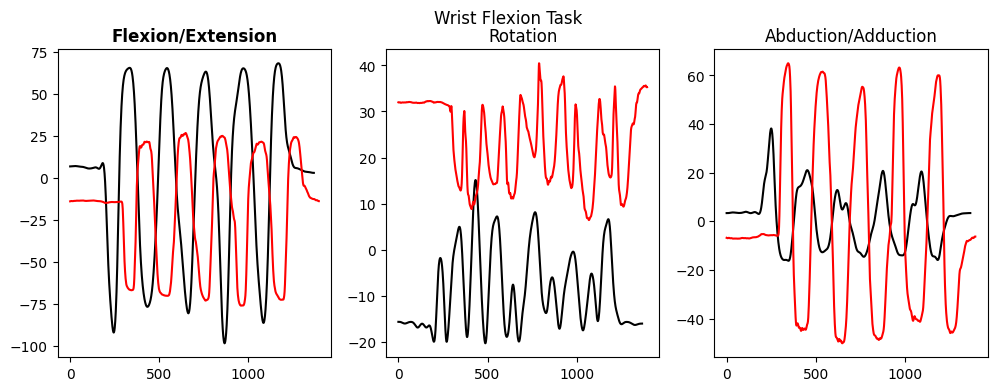

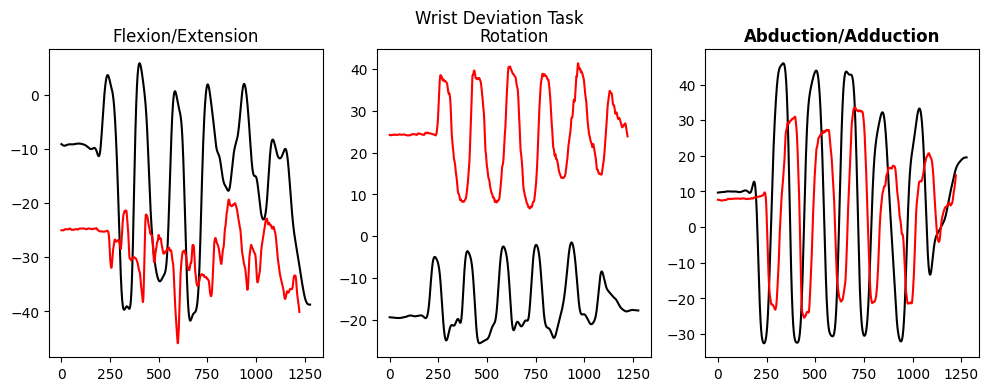

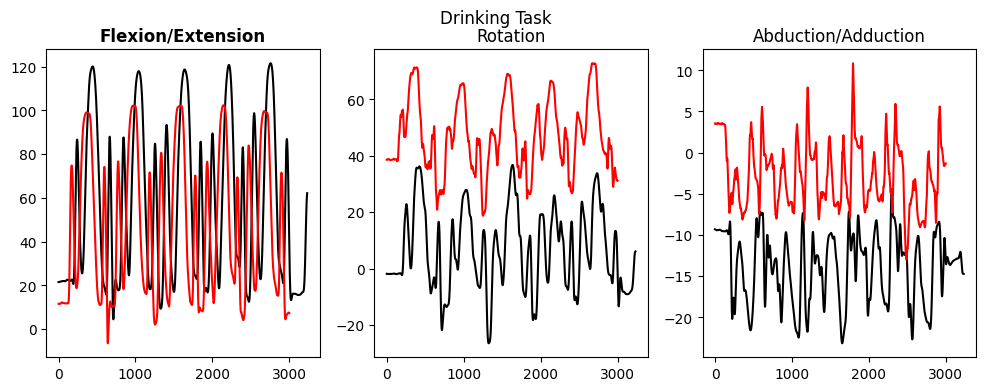

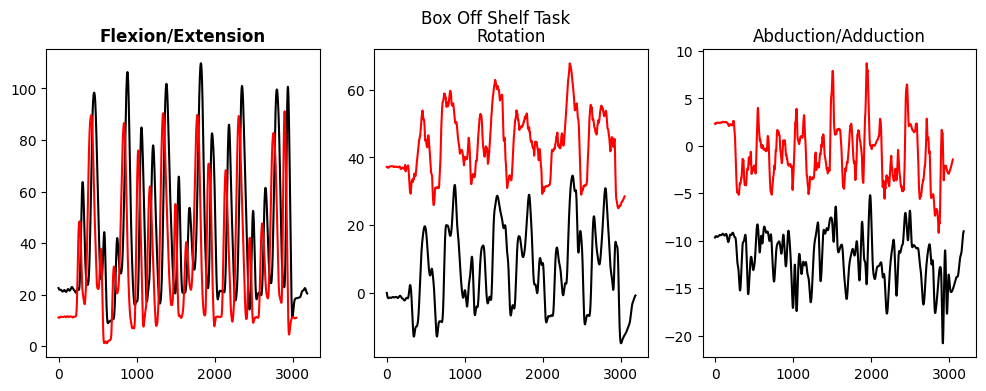

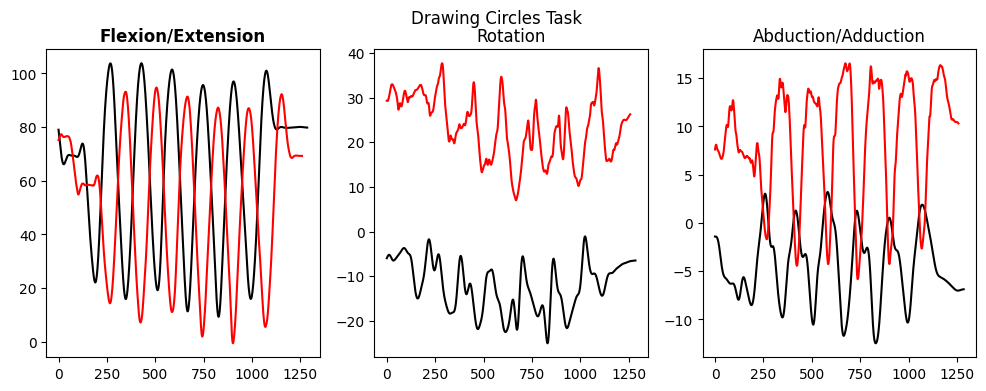

In [3]:
#### Plot data before the aligment
for task in range(len(alignment_dict)):
    joint = alignment_dict[task]['Joint']
    
    imu = IMU[task][joint]
    opto = OPTO[task][joint]
    taskName = IMU[task]['Task Name']
    
    fig, axList = plt.subplots(1,3,figsize=(12,4))
    fig.suptitle(taskName)
    jointAxesNames = ['Flexion/Extension', 'Rotation', 'Abduction/Adduction']
    for i in range(3):
        axList[i].plot(opto[:,i], color='black', label='OPTO')
        axList[i].plot(imu[:,i], color='red', label='IMU N-Pose')
        axList[i].set_title(jointAxesNames[i])
        if i == alignment_dict[task]['Axis']:
            axList[i].set_title(jointAxesNames[i], fontweight='bold')

Condition 2) imu < opto and lag +


Text(0.5, 1.0, 'Signals aligned and cropped')

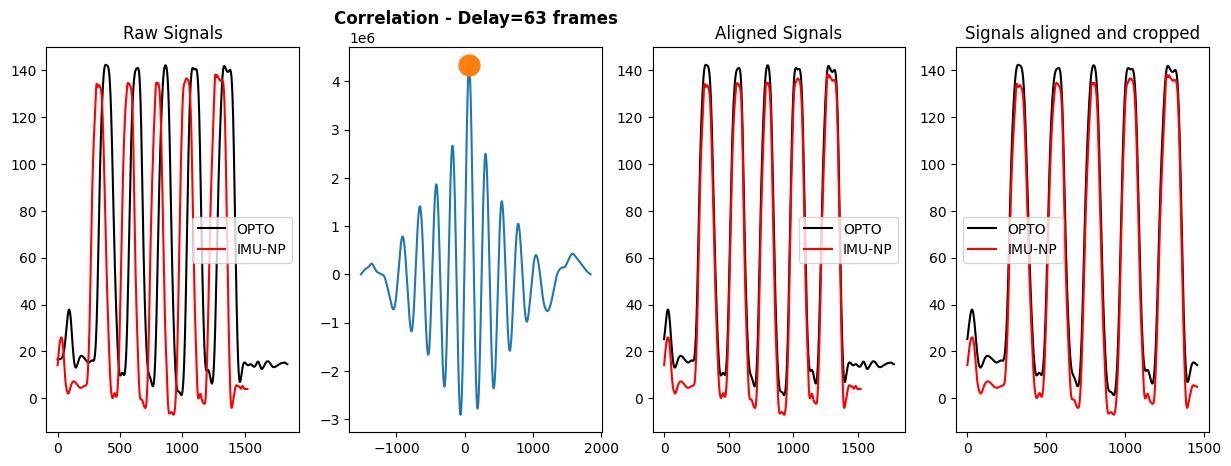

In [4]:
## Cross-correlation of two signals
task = 0
joint = alignment_dict[task]['Joint']
axis = alignment_dict[task]['Axis']

imu = IMU[task][joint][:,axis]
opto = OPTO[task][joint][:,axis]


    
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(15,5))

ax1.plot(opto, color='black')
ax1.plot(imu, color='red')
ax1.set_title('Raw Signals')
ax1.legend(['OPTO', 'IMU-NP'])

correlation = correlate(opto - np.mean(opto), imu - np.mean(imu), mode='full', method='direct')
lags = correlation_lags(opto.size, imu.size, mode='full')
lag = lags[np.argmax(correlation)]
ax2.plot(lags, correlation)
ax2.plot(lags[np.argmax(correlation)], correlation[np.argmax(correlation)], marker='o', markersize=15)
ax2.set_title(f'Correlation - Delay={lag} frames', fontweight='bold')

# Quick way to check if signals are aligned properly
if lag>=0:
    ax3.plot(opto[lag:], color='black')
    ax3.plot(imu, color='red')
    ax3.set_title('Aligned Signals')
    ax3.legend(['OPTO', 'IMU-NP'])
else:
    ax3.plot(opto, color='black')
    ax3.plot(imu[abs(lag):], color='red')
    ax3.set_title('Aligned Signals')
    ax3.legend(['OPTO', 'IMU-NP'])

# imu_len = len(imu)
# opto_len = len(opto)
# print(f'imu = {imu_len} - opto = {opto_len} - lag = {lag} frames')

### Now we need to find the matching indices to align the IMU signal to the opto signal. We don't touch the OPTO since it is our reference
# 4 conditions exist:
# 1) len(imu) > len(opto) and lag > 0 -> imu simply needs to be cropped and imu is shifted forward
# 2) len(imu) < len(opto) and lag > 0 -> imu needs to be padded and imu is shifted forward
# 3) len(imu) > len(opto) and lag < 0 -> imu needs to be cropped and imu is shifted backward
# 4) len(imu) < len(opto) and lag < 0 -> imu needs to be padded and imu is shifted backward

if len(imu) >= len(opto) and lag >= 0:
    print('Condition 1) imu > opto and lag +')
    # This condition doesn't occur with our dataset. We add it for completeness but it is not double checked
    first_frame_opto = lag
    last_frame_opto = len(imu)
    first_frame_imu = len(opto)-len(imu)
    last_frame_imu = len(imu)-lag
elif len(imu) < len(opto) and lag >= 0:
    print('Condition 2) imu < opto and lag +')
    first_frame_opto = lag
    last_frame_opto = len(imu)
    first_frame_imu = 0
    last_frame_imu = len(imu)-lag
elif len(imu) >= len(opto) and lag < 0:
    print('Condition 3) imu > opto and lag -')
    first_frame_opto = 0
    last_frame_opto = len(imu)- abs(lag)
    first_frame_imu = abs(lag)
    last_frame_imu = len(imu)
elif len(imu) < len(opto) and lag < 0:
    print('Condition 4) imu < opto and lag -')
    first_frame_opto = 0
    last_frame_opto = len(imu) - abs(lag)
    first_frame_imu = abs(lag)
    last_frame_imu = len(imu)

ax4.plot(opto[first_frame_opto:last_frame_opto], color='black')
ax4.plot(imu[first_frame_imu:last_frame_imu], color='red')
ax4.legend(['OPTO', 'IMU-NP'])
ax4.set_title('Signals aligned and cropped')
